# Packages

In [1]:
import pandas as pd
import numpy as np 
import os
import h5py
import torch
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as TF
from sklearn.metrics import f1_score,confusion_matrix
import matplotlib.pyplot as plt

# Config

In [2]:
dataset_path = '/kaggle/input/mmwave-dataset/mmwave_dataset/'
learning_rate = 1e-4          # 學習率 （可調整）
lstm_hidden_size = 128       # LSTM 隱藏層大小 (可調整)
lstm_num_layers = 2         # LSTM 深度 （可調整）
fc_output_size = 8         # 最終輸出大小（8個分類）
num_epochs = 16            # 訓練次數 （可調整）
training_set = 0.8         # 訓練集比例  90% 剩下為驗證集 （可調整）
my_batch_size = 16      # 批次大小
augment_size = 9 #增強幾個資料
# 要分類的標籤
label_list = ['background','focus', 'turn_left', 'turn_right', 'turn_up', 'turn_down', 'zoom_in', 'zoom_out']
# 標籤對應字典
label_map = {label: idx for idx, label in enumerate(label_list)}
label_map_invert = {idx: label for idx, label in enumerate(label_list)}

# CUDA

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Other Function

In [4]:
# 列出子資料夾
def list_sub(directory_path):
    all_items = os.listdir(directory_path)
    
    subdirectories = [item for item in all_items if os.path.isdir(os.path.join(directory_path, item))]
    
    return subdirectories

# 列出所有 h5 的檔案
def list_h5(directory_path):
    all_files = os.listdir(directory_path)
    
    h5_files = [f for f in all_files if f.endswith('.h5') and os.path.isfile(os.path.join(directory_path, f))]
    
    return h5_files

# 資料增強
def translate_image(image, max_translate=2):
    # 隨機選擇上下左右移動的像素數
    dx = np.random.randint(-max_translate, max_translate + 1)
    dy = np.random.randint(-max_translate, max_translate + 1)
    return TF.affine(image, angle=0, translate=(dx, dy), scale=1, shear=0)

# 噪聲
def add_noise(image, mean=0, std=0.15):
    # 生成高斯噪聲
    noise = torch.randn(image.size()) * std + mean
    # 加到圖像中
    noisy_image = image + noise

    return noisy_image

# 每幀都要
def augment_frame(frame, max_translate=2):
    frame = translate_image(frame, max_translate)
#     frame = add_noise(frame)
    return frame

# 對整個序列增強
def augment_sequence(sequence):
    augmented_sequence = []
    # 對每幀增強
    for i in range(sequence.shape[2]):
        frame = sequence[:, :, i]
        frame_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0)
        augmented_frame = augment_frame(frame_tensor)
        augmented_sequence.append(augmented_frame.squeeze(0))
    
    # 增強完再疊回去
    return torch.stack(augmented_sequence, dim=2)
# 對整個序列增強
def augment_sequence_back(sequence):
    augmented_sequence = []
    # 對每幀增強
    for i in range(sequence.shape[2]):
        frame = sequence[:, :, i]
        frame_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0)
        augmented_frame = augment_frame(frame_tensor)
        augmented_frame = add_noise(augmented_frame)
        augmented_sequence.append(augmented_frame.squeeze(0))
    
    # 增強完再疊回去
    return torch.stack(augmented_sequence, dim=2)
# 對整個序列增強
def augment_sequence_new(sequence):
    augmented_sequence = []
    # 對每幀增強
    for i in range(sequence.shape[2]):
        frame = sequence[:, :, i]
        frame_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0)
        augmented_frame = augment_frame(frame_tensor, max_translate=2)
        augmented_sequence.append(augmented_frame.squeeze(0))
    
    # 增強完再疊回去
    return torch.stack(augmented_sequence, dim=2)


# Model

In [5]:
class ConvLSTMNet(nn.Module):
    def __init__(self, lstm_num_layers, lstm_hidden_size, fc_output_size):
        super(ConvLSTMNet, self).__init__()
        
        # 定義卷積層
        # RDI & PHD 卷積
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 16x16 feature map
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 8x8 feature map
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # 4x4 feature map
        )
         
        # 計算卷積後輸出的特徵圖大小
        # 最終大小為 4x4 , 然後有512個通道
        self.flattened_size = 512 * 4 * 4
        
        # 定義 LSTM 層
        self.lstm = nn.LSTM(
            input_size = self.flattened_size * 2, 
            hidden_size = lstm_hidden_size, 
            num_layers = lstm_num_layers, 
            batch_first = True
        )
        
        # 定義全連接層
        self.fc = nn.Linear(lstm_hidden_size, fc_output_size)
        
    def forward(self, rdi_map, phd_map):
        # 批次大小,  幀數 , 32, 32
        batch_size, timesteps, _, _ = rdi_map.size()
        
        # 初始化 LSTM 隱藏狀態 並確保他的device跟輸入一樣
        h0 = torch.zeros(lstm_num_layers, batch_size, lstm_hidden_size).to(rdi_map.device)
        c0 = torch.zeros(lstm_num_layers, batch_size, lstm_hidden_size).to(rdi_map.device)
        
        # 結合兩個Map的卷積結果
        combined_features = []
        
        for t in range(timesteps):
            rdi_frame = rdi_map[:, t, :, :].unsqueeze(1)  # (batch_size, 1, 32, 32)
            rdi_conv_output = self.conv(rdi_frame)  # (batch_size, 64, 8, 8)
            rdi_conv_output = rdi_conv_output.view(batch_size, -1)  # 攤平 (batch_size, 64*8*8)
            
            phd_frame = phd_map[:, t, :, :].unsqueeze(1)
            phd_conv_output = self.conv(phd_frame)  # (batch_size, 64, 8, 8)
            phd_conv_output = phd_conv_output.view(batch_size, -1)  # 展平 (batch_size, 64*8*8)
            
            # 將兩個卷積輸出並在一起
            combined_feature = torch.cat((rdi_conv_output, phd_conv_output), dim=1)  # (batch_size, flattened_size*2)
            combined_features.append(combined_feature)
        
        # 把所有時間點的特徵結合成一個序列 (batch_size, timesteps, flattened_size*2)
        combined_features = torch.stack(combined_features, dim=1)

        # 把特徵序列輸入到LSTM中
        lstm_out, _ = self.lstm(combined_features, (h0, c0))
        
        # 取 LSTM 最後的輸出
        lstm_out_last = lstm_out[:, -1, :]
        
        # 全連接層
        out = self.fc(lstm_out_last)
        
        return out


model = ConvLSTMNet(lstm_num_layers, lstm_hidden_size, fc_output_size)
model.to(device)
# 檢查模型結構
print(model)


ConvLSTMNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(16384, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)


In [6]:
print(list_sub(dataset_path))
print(list_h5(dataset_path+list_sub(dataset_path)[0]))

['focus', 'turn_down', 'turn_left', 'zoom_out', 'turn_right', 'turn_up', 'zoom_in']
['focus_19.h5', 'focus_10.h5', 'focus_8.h5', 'focus_5.h5', 'focus_7.h5', 'focus_18.h5', 'focus_11.h5', 'focus_4.h5', 'focus_12.h5', 'focus_17.h5', 'focus_13.h5', 'focus_1.h5', 'focus_14.h5', 'focus_15.h5', 'focus_16.h5', 'focus_9.h5', 'focus_6.h5', 'focus_2.h5', 'focus_3.h5', 'focus_20.h5']


In [7]:
with h5py.File('/kaggle/input/mmwave-dataset/mmwave_dataset/focus/focus_1.h5','r') as file:
    for name, obj in file.items():
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name} - Shape: {obj.shape}, Dtype: {obj.dtype}")

Dataset: AXIS - Shape: (0, 0), Dtype: float16
Group: DATA_CONFIG
Dataset: DS1 - Shape: (2, 32, 32, 100), Dtype: float16
Group: DSP_CONFIG
Dataset: FRAME_COUNT - Shape: (100, 2), Dtype: uint16
Dataset: LABEL - Shape: (100, 1), Dtype: uint16
Group: RF_CONFIG
Group: VIDEO_CONFIG


# DataLoader

In [8]:
class MMWaveDataset(Dataset):
    def __init__(self, file_path, dataset_name):
        self.dataItem = [] 
        
        # For Background
        with h5py.File('/kaggle/input/mmwave-background/background.h5', 'r') as file:
            self.dataItem.append((file[dataset_name][0], file[dataset_name][1],'background'))
            for augment_times in range(augment_size*20):
                augmented_sequence_rdi = augment_sequence_back(file[dataset_name][0])
                augmented_sequence_phd = augment_sequence_back(file[dataset_name][1])
                self.dataItem.append((augmented_sequence_rdi, augmented_sequence_phd, 'background'))
        
        # For Zoom in-out , Turn down-up new gesture
        dataset_path_new = '/kaggle/input/mmwave-dataset-new-2/new2/'
        for gesture_type in list_sub(dataset_path_new):
            print(gesture_type+":開始生成")
            h5_files = list_h5(dataset_path_new+gesture_type)
            for filename in h5_files:
                with h5py.File(dataset_path_new+gesture_type+'/'+filename, 'r') as file:
                    self.dataItem.append((file[dataset_name][0], file[dataset_name][1], gesture_type))
                    augment_size_h = augment_size
                    for augment_times in range(augment_size_h):
                        augmented_sequence_rdi = augment_sequence_new(file[dataset_name][0])
#                         print(augmented_sequence_rdi.shape)
                        augmented_sequence_phd = augment_sequence_new(file[dataset_name][1])
                        self.dataItem.append((augmented_sequence_rdi, augmented_sequence_phd, gesture_type))
            print(gesture_type+":生成結束")        
            
        # For Other gestures
        for gesture_type in list_sub(dataset_path):
            if gesture_type == 'turn_up' or gesture_type == 'turn_down' or gesture_type == 'zoom_in' or gesture_type == 'zoom_out':
                print('跳過 '+gesture_type)
                continue
            print(gesture_type+":開始生成")
            h5_files = list_h5(dataset_path+gesture_type)
            for filename in h5_files:
                with h5py.File(dataset_path+gesture_type+'/'+filename, 'r') as file:
                    
                    self.dataItem.append((file[dataset_name][0], file[dataset_name][1], gesture_type))
                    augment_size_h = augment_size
                        
                    for augment_times in range(augment_size_h):
                        augmented_sequence_rdi = augment_sequence(file[dataset_name][0])

                        augmented_sequence_phd = augment_sequence(file[dataset_name][1])
                        self.dataItem.append((augmented_sequence_rdi, augmented_sequence_phd, gesture_type))
            print(gesture_type+":生成結束")

    def __len__(self):
        return len(self.dataItem)
    
    def __getitem__(self, idx):
        rdi_map = self.dataItem[idx][0]
        phd_map = self.dataItem[idx][1]
        target   = self.dataItem[idx][2]
        target = label_map[target]
        
        if isinstance(rdi_map, torch.Tensor):
            rdi_map = rdi_map.clone().detach().permute(2, 0, 1).to(device)
        else:
            rdi_map = torch.tensor(rdi_map, dtype=torch.float32).permute(2, 0, 1).to(device)

        if isinstance(phd_map, torch.Tensor):
            phd_map = phd_map.clone().detach().permute(2, 0, 1).to(device)
        else:
            phd_map = torch.tensor(phd_map, dtype=torch.float32).permute(2, 0, 1).to(device)
            
        target = torch.tensor(target, dtype=torch.long).to(device)
        return rdi_map, phd_map, target


dataset = MMWaveDataset(dataset_path, 'DS1')

dataset_size = len(dataset)
train_size = int(training_set* dataset_size)
val_size = dataset_size - train_size
print(dataset_size)
# 分割訓練和驗證集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=my_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=my_batch_size, shuffle=False)

turn_down:開始生成
turn_down:生成結束
zoom_out:開始生成
zoom_out:生成結束
turn_up:開始生成
turn_up:生成結束
zoom_in:開始生成
zoom_in:生成結束
focus:開始生成
focus:生成結束
跳過 turn_down
turn_left:開始生成
turn_left:生成結束
跳過 zoom_out
turn_right:開始生成
turn_right:生成結束
跳過 turn_up
跳過 zoom_in
1561


# Loss Function & Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    
    # 訓練部份
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_train_targets = []
    all_train_predictions = []
    
    for rdi_map, phd_map, targets in tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]', unit='batch'):
 
        outputs = model(rdi_map, phd_map)
            
        _, predicted_classes = torch.max(outputs, 1)
        
        all_train_targets.extend(targets.cpu().numpy())
        all_train_predictions.extend(predicted_classes.cpu().numpy())
        
        
        correct_predictions += (predicted_classes == targets).sum().item()
        total_samples += targets.size(0)
        
        loss = criterion(outputs, targets) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss/len(train_loader)
    train_accuracy = correct_predictions / total_samples * 100
    train_f1 = f1_score(all_train_targets, all_train_predictions, average='weighted')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # 驗證部份
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    all_val_targets = []
    all_val_predictions = []
    
    with torch.no_grad():
        for rdi_map, phd_map, targets in val_loader:
            outputs = model(rdi_map, phd_map)
            
            _, predicted_classes = torch.max(outputs, 1)
            
            all_val_targets.extend(targets.cpu().numpy())
            all_val_predictions.extend(predicted_classes.cpu().numpy())
            
            val_correct_predictions += (predicted_classes == targets).sum().item()
            val_total_samples += targets.size(0)
            
            loss = criterion(outputs, targets)
            
            val_running_loss += loss.item()
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_samples * 100
    val_f1 = f1_score(all_val_targets, all_val_predictions, average='weighted')
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1-Score: {train_f1:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1-Score: {val_f1:.4f}')

    
print("Training complete")


Epoch [1/16]: 100%|██████████| 78/78 [00:48<00:00,  1.62batch/s]


Epoch [1/16]
Train Loss: 1.6964, Train Accuracy: 58.25%, Train F1-Score: 0.5480
Validation Loss: 1.2465, Validation Accuracy: 81.15%, Validation F1-Score: 0.8066


Epoch [2/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [2/16]
Train Loss: 0.7545, Train Accuracy: 93.19%, Train F1-Score: 0.9317
Validation Loss: 0.4377, Validation Accuracy: 96.49%, Validation F1-Score: 0.9649


Epoch [3/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [3/16]
Train Loss: 0.2618, Train Accuracy: 98.32%, Train F1-Score: 0.9832
Validation Loss: 0.2780, Validation Accuracy: 95.21%, Validation F1-Score: 0.9518


Epoch [4/16]: 100%|██████████| 78/78 [00:47<00:00,  1.64batch/s]


Epoch [4/16]
Train Loss: 0.1524, Train Accuracy: 98.72%, Train F1-Score: 0.9872
Validation Loss: 0.1478, Validation Accuracy: 98.72%, Validation F1-Score: 0.9871


Epoch [5/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [5/16]
Train Loss: 0.1282, Train Accuracy: 98.40%, Train F1-Score: 0.9839
Validation Loss: 0.1190, Validation Accuracy: 98.72%, Validation F1-Score: 0.9872


Epoch [6/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [6/16]
Train Loss: 0.2779, Train Accuracy: 95.35%, Train F1-Score: 0.9536
Validation Loss: 0.1785, Validation Accuracy: 98.40%, Validation F1-Score: 0.9841


Epoch [7/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [7/16]
Train Loss: 0.1017, Train Accuracy: 99.28%, Train F1-Score: 0.9928
Validation Loss: 0.0967, Validation Accuracy: 98.72%, Validation F1-Score: 0.9871


Epoch [8/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [8/16]
Train Loss: 0.0583, Train Accuracy: 99.60%, Train F1-Score: 0.9960
Validation Loss: 0.0754, Validation Accuracy: 99.04%, Validation F1-Score: 0.9904


Epoch [9/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [9/16]
Train Loss: 0.0460, Train Accuracy: 99.76%, Train F1-Score: 0.9976
Validation Loss: 0.0454, Validation Accuracy: 99.68%, Validation F1-Score: 0.9968


Epoch [10/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [10/16]
Train Loss: 0.0327, Train Accuracy: 99.92%, Train F1-Score: 0.9992
Validation Loss: 0.0343, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [11/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [11/16]
Train Loss: 0.0764, Train Accuracy: 98.64%, Train F1-Score: 0.9864
Validation Loss: 0.0762, Validation Accuracy: 98.72%, Validation F1-Score: 0.9870


Epoch [12/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [12/16]
Train Loss: 0.0963, Train Accuracy: 98.56%, Train F1-Score: 0.9855
Validation Loss: 0.0727, Validation Accuracy: 98.40%, Validation F1-Score: 0.9839


Epoch [13/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [13/16]
Train Loss: 0.0336, Train Accuracy: 99.84%, Train F1-Score: 0.9984
Validation Loss: 0.0273, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [14/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [14/16]
Train Loss: 0.0201, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0218, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [15/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [15/16]
Train Loss: 0.0165, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0184, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000


Epoch [16/16]: 100%|██████████| 78/78 [00:47<00:00,  1.63batch/s]


Epoch [16/16]
Train Loss: 0.0150, Train Accuracy: 100.00%, Train F1-Score: 1.0000
Validation Loss: 0.0175, Validation Accuracy: 100.00%, Validation F1-Score: 1.0000
Training complete


# Plot

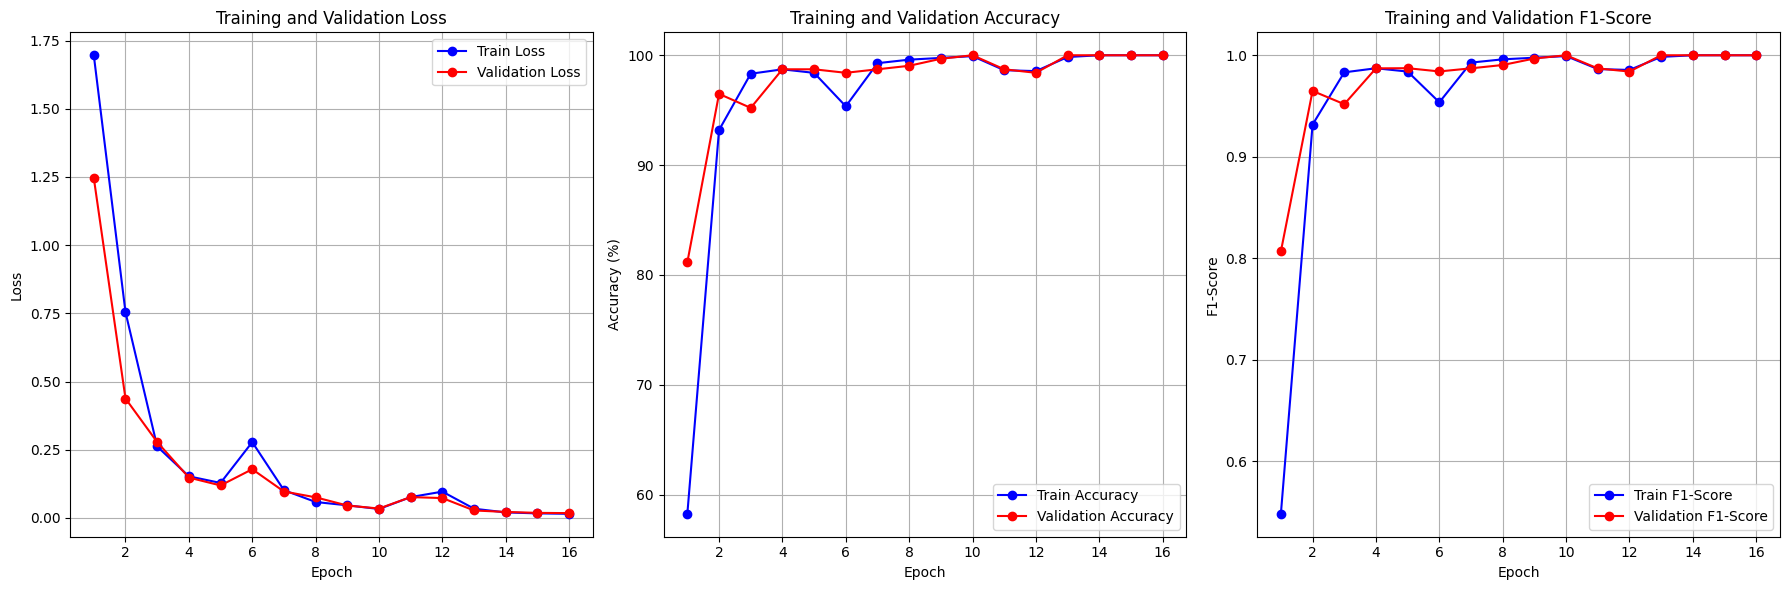

In [11]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(18, 6))

# Loss Graph
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy Graph
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# F1-Score
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1_scores, 'bo-', label='Train F1-Score')
plt.plot(epochs, val_f1_scores, 'ro-', label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Training and Validation F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Model Output (輸出訓練完成的模型)

In [12]:
model_path = "mmwave_model_v2.pth"
torch.save(model, model_path)